In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from pydtmc import MarkovChain
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
# Descargar datos de una acción
ticker = yf.Ticker("NU")
datos = ticker.history(period="1y")  # último año
# O con fechas específicas
datos = ticker.history(start="2020-01-01", end="2024-12-23")

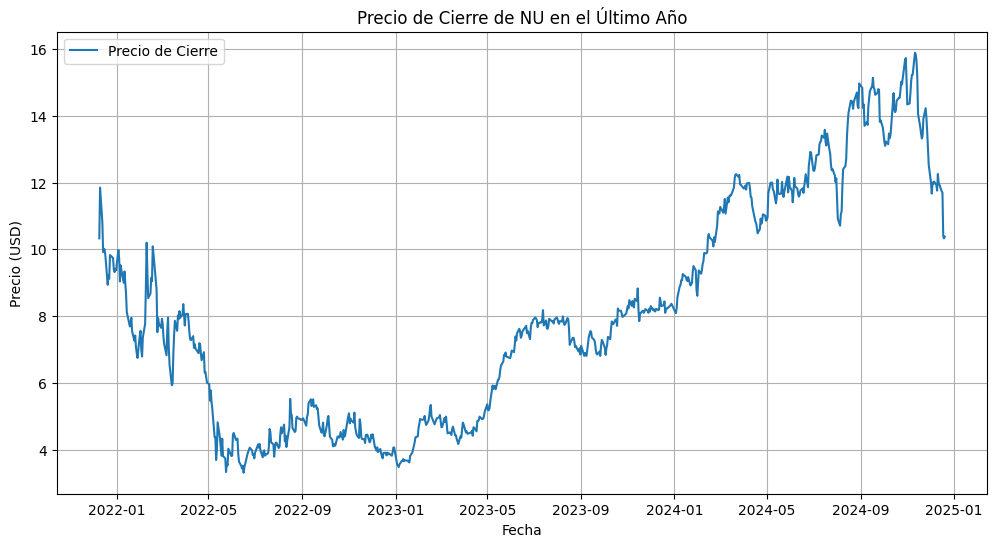

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(datos.index, datos['Close'], label='Precio de Cierre')
plt.title('Precio de Cierre de NU en el Último Año')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.savefig('precio_cierre_nu.png')
plt.show()

In [23]:
datos['Diff'] = datos['Close'].diff()
datos['Dir'] = datos['Diff'].apply(lambda x: 'U' if x >= 0 else 'D')

In [24]:
datos['Prev_Dir'] = datos['Dir'].shift(1)
datos['State'] = datos['Prev_Dir'] + datos['Dir']

In [25]:
datos.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Dir,Prev_Dir,State,Diff
Date,,,,,,,,,,,
2021-12-09 00:00:00-05:00,11.25,12.24,10.01,10.33,90160800,0.0,0.0,D,None,NaN,NaN
2021-12-10 00:00:00-05:00,11.45,11.85,9.80,11.85,50077300,0.0,0.0,U,D,DU,1.52
2021-12-13 00:00:00-05:00,11.10,11.29,10.31,10.81,19658400,0.0,0.0,D,U,UD,-1.04
2021-12-14 00:00:00-05:00,10.55,10.58,9.27,9.92,22728100,0.0,0.0,D,D,DD,-0.89
2021-12-15 00:00:00-05:00,9.63,10.29,9.42,10.01,12663900,0.0,0.0,U,D,DU,0.09


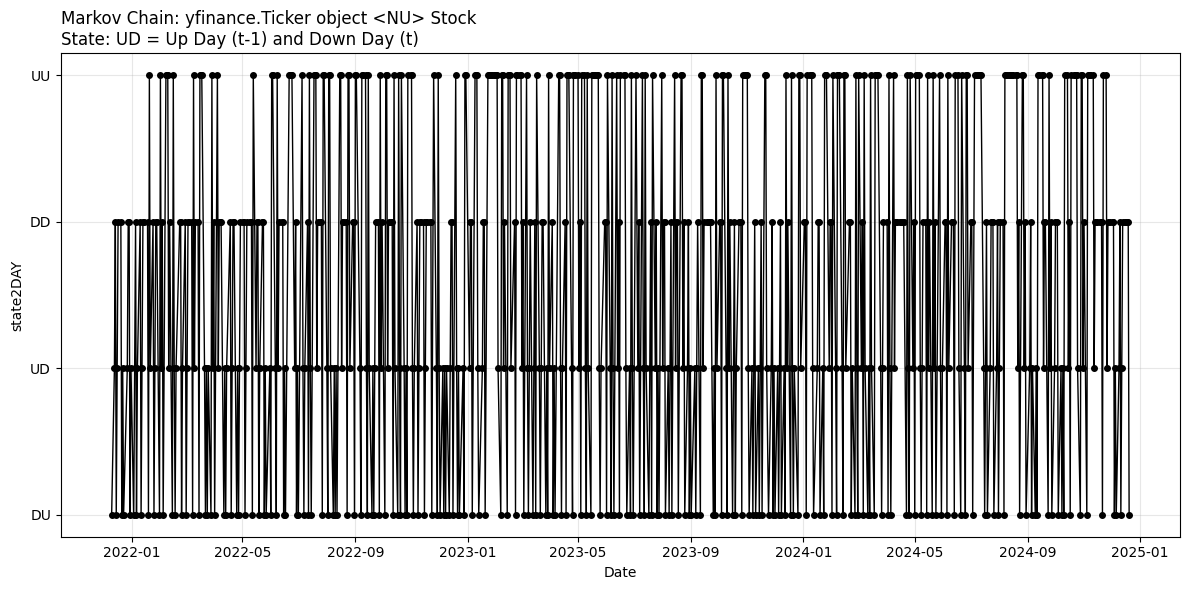

In [69]:
# Eliminamos la primera fila que tendrá valores NaN
df_plot = datos.dropna(subset=['State']).copy()

# 4. Configurar el orden de los estados en el eje Y (según tu imagen)
state_order = ['DD', 'DU', 'UD', 'UU']
df_plot['State'] = pd.Categorical(df_plot['State'], categories=state_order, ordered=True)

# 5. Visualización
plt.figure(figsize=(12, 6))

# Graficamos los puntos y la línea que los une
plt.plot(df_plot.index, df_plot['State'], marker='o', color='black', 
         linestyle='-', linewidth=1, markersize=4)

# Formateo del gráfico
plt.title(f'Markov Chain: {ticker} Stock\nState: UD = Up Day (t-1) and Down Day (t)', loc='left')
plt.ylabel('state2DAY')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

# Ajustar los límites y etiquetas del eje Y
plt.yticks(state_order)

plt.tight_layout()
plt.savefig('states_mapping.png')
plt.show()

In [27]:
df_plot["State"].value_counts().sort_index()

State
DD    181
DU    190
UD    189
UU    202
Name: count, dtype: int64

In [30]:
def calcular_matriz_transicion(serie_estados):
    estados_unicos = sorted(serie_estados.unique())
    n = len(estados_unicos)
    matriz = np.zeros((n, n))
    
    # Mapear estados a índices
    estado_a_idx = {estado: i for i, estado in enumerate(estados_unicos)}
    
    # Contar transiciones
    for i in range(len(serie_estados) - 1):
        estado_actual = serie_estados.iloc[i]
        estado_siguiente = serie_estados.iloc[i + 1]
        idx_actual = estado_a_idx[estado_actual]
        idx_siguiente = estado_a_idx[estado_siguiente]
        matriz[idx_actual][idx_siguiente] += 1
    
    # Normalizar para obtener probabilidades
    for i in range(n):
        suma_fila = matriz[i].sum()
        if suma_fila > 0:
            matriz[i] = matriz[i] / suma_fila
    
    return matriz, estados_unicos

In [32]:
matriz_transicion, estados_unicos = calcular_matriz_transicion(df_plot['State'])

In [33]:
print(pd.DataFrame(matriz_transicion, 
                   index=estados_unicos, 
                   columns=estados_unicos))

          DD        DU        UD        UU
DD  0.464088  0.535912  0.000000  0.000000
DU  0.000000  0.000000  0.476190  0.523810
UD  0.513228  0.486772  0.000000  0.000000
UU  0.000000  0.000000  0.490099  0.509901


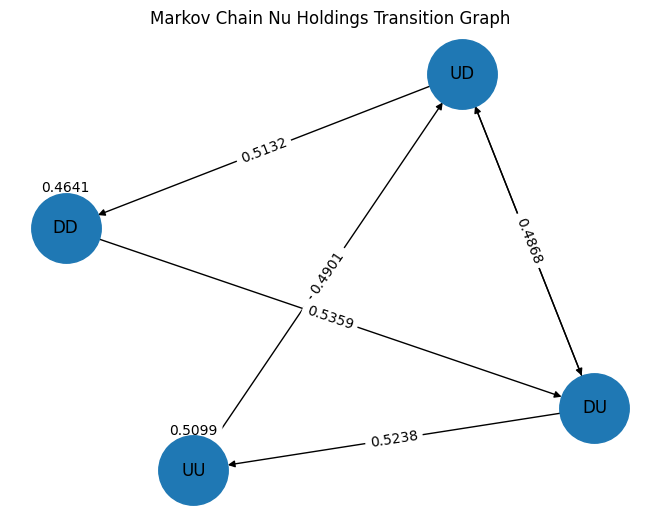

In [68]:
mc = MarkovChain(matriz_transicion, estados_unicos)

# Crear grafo dirigido
G = nx.from_numpy_array(matriz_transicion, create_using=nx.DiGraph)

mapping = dict(enumerate(estados_unicos))
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2500,
    arrows=True
)

# Extraer pesos
edge_labels = {
    (u, v): f"{d['weight']:.4f}"
    for u, v, d in G.edges(data=True)
}

# Mostrar pesos en las aristas
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels
)

plt.title('Markov Chain Nu Holdings Transition Graph')
plt.savefig('markov_chain_nu_holdings.png')
plt.show()